## 00. 환경설정

In [1]:
import re
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
from tqdm import tqdm
%matplotlib inline

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore")

C:\Users\kimminsu\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## 01. LDA 모델 맛보기
- scikit learn에서 제공하는 텍스트 데이터를 가지고 LDA 모델을 학습해봅니다.
- 추천 데이터는 아니지만 LDA를 파악하기 위해 간단한 실습을 수행합니다.

In [2]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
len(documents)

11314

- 문서(document) 예시

In [3]:
documents[1]

"\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism?  No, you need a little leap of faith, Jimmy.  Your logic runs out\nof steam!\n\n\n\n\n\n\n\nJim,\n\nSorry I can't pity you, Jim.  And I'm sorry that you have these feelings of\ndenial about the faith you need to get by.  Oh well, just pretend that it will\nall end happily ever after anyway.  Maybe if you start a new newsgroup,\nalt.atheist.hard, you won't be bummin' so much?\n\n\n\n\n\n\nBye-Bye, Big Jim.  Don't forget your Flintstone's Chewables!  :) \n--\nBake Timmons, III"

### 텍스트 데이터 전처리

In [4]:
news_df = pd.DataFrame({"document" : documents})

# 문서 내 특수문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")

# 문서 내 길이가 3 이하인 단어 제거
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))

# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())
news_df

,document,clean_doc
0,Well i'm not sure about the story nad it did s...,well sure about story seem biased what disagre...
1,"\n\n\n\n\n\n\nYeah, do you expect people to re...",yeah expect people read actually accept hard a...
2,Although I realize that principle is not one o...,although realize that principle your strongest...
3,Notwithstanding all the legitimate fuss about ...,notwithstanding legitimate fuss about this pro...
4,"Well, I will have to change the scoring on my ...",well will have change scoring playoff pool unf...
...,...,...
11309,"Danny Rubenstein, an Israeli journalist, will ...",danny rubenstein israeli journalist will speak...
11310,\n,
11311,\nI agree. Home runs off Clemens are always m...,agree home runs clemens always memorable kinda...
11312,I used HP DeskJet with Orange Micros Grappler ...,used deskjet with orange micros grappler syste...


#### 1차 전처리 document 예시

In [5]:
news_df['clean_doc'][1]

'yeah expect people read actually accept hard atheism need little leap faith jimmy your logic runs steam sorry pity sorry that have these feelings denial about faith need well just pretend that will happily ever after anyway maybe start newsgroup atheist hard bummin much forget your flintstone chewables bake timmons'

#### Stopwords 제거를 위한 nltk 라이브러리

In [6]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kimminsu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


- stopwords 예시

In [7]:
stop_words[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

### 문서 tokenize 이후 stopwords 제거

In [8]:
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

### 학습에 사용할 최종 데이터
- document를 word로 이루어진 list 형태로 변환
- 추천 데이터의 경우 document = user, word = item의 형태로 구성

In [9]:
tokenized_doc[1]

['yeah',
 'expect',
 'people',
 'read',
 'actually',
 'accept',
 'hard',
 'atheism',
 'need',
 'little',
 'leap',
 'faith',
 'jimmy',
 'logic',
 'runs',
 'steam',
 'sorry',
 'pity',
 'sorry',
 'feelings',
 'denial',
 'faith',
 'need',
 'well',
 'pretend',
 'happily',
 'ever',
 'anyway',
 'maybe',
 'start',
 'newsgroup',
 'atheist',
 'hard',
 'bummin',
 'much',
 'forget',
 'flintstone',
 'chewables',
 'bake',
 'timmons']

- gensim에서 지원하는 dictionary

In [10]:
id2word = corpora.Dictionary(tokenized_doc)

- document를 TF 형태로 변환

In [11]:
corpus = [id2word.doc2bow(text) for text in tokenized_doc]
print(corpus[1])

[(52, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 2), (67, 1), (68, 1), (69, 1), (70, 1), (71, 2), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 2), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 2), (86, 1), (87, 1), (88, 1), (89, 1)]


- 개별 단어는 id의 형태로 변환되어 모델에 사용

In [12]:
id2word[52]

'well'

- document 1의 예시

In [13]:
[(id, id2word[id], freq) for id, freq in corpus[1]]

[(52, 'well', 1),
 (55, 'accept', 1),
 (56, 'actually', 1),
 (57, 'anyway', 1),
 (58, 'atheism', 1),
 (59, 'atheist', 1),
 (60, 'bake', 1),
 (61, 'bummin', 1),
 (62, 'chewables', 1),
 (63, 'denial', 1),
 (64, 'ever', 1),
 (65, 'expect', 1),
 (66, 'faith', 2),
 (67, 'feelings', 1),
 (68, 'flintstone', 1),
 (69, 'forget', 1),
 (70, 'happily', 1),
 (71, 'hard', 2),
 (72, 'jimmy', 1),
 (73, 'leap', 1),
 (74, 'little', 1),
 (75, 'logic', 1),
 (76, 'maybe', 1),
 (77, 'much', 1),
 (78, 'need', 2),
 (79, 'newsgroup', 1),
 (80, 'people', 1),
 (81, 'pity', 1),
 (82, 'pretend', 1),
 (83, 'read', 1),
 (84, 'runs', 1),
 (85, 'sorry', 2),
 (86, 'start', 1),
 (87, 'steam', 1),
 (88, 'timmons', 1),
 (89, 'yeah', 1)]

## 02. Gensim LDA 학습
- gensim에서 제공하는 lda 모델링
- 하이퍼 파라미터는 [API 문서 참고](https://radimrehurek.com/gensim/models/ldamodel.html)
- multicore를 지원하여 빠르게 학습하는 LdaMulticore 모델을 사용 가능

### LDA 모델 학습

In [14]:
topic_num = 20

ldamodel = gensim.models.ldamodel.LdaModel(corpus,
                                          num_topics = topic_num,
                                          id2word = id2word,
                                          passes=10,
                                          per_word_topics=True)

#### 특정 Topic의 Top 5 단어

In [15]:
topic = 0
topn = 5

for id, prob in ldamodel.get_topic_terms(topic, topn=topn):
    print(ldamodel.id2word[id], prob)

jesus 0.021902012
christian 0.012947079
bible 0.012267443
church 0.010227376
christ 0.008986625


#### Topic 별 Top 5 단어 출력

In [16]:
topics = ldamodel.print_topics(num_words = 5)
for topic in topics:
    print(topic)

(0, '0.022*"jesus" + 0.013*"christian" + 0.012*"bible" + 0.010*"church" + 0.009*"christ"')
(1, '0.013*"water" + 0.009*"wiring" + 0.007*"smokeless" + 0.007*"power" + 0.007*"dept"')
(2, '0.026*"keyboard" + 0.022*"monitor" + 0.014*"offer" + 0.012*"asking" + 0.012*"condition"')
(3, '0.013*"circuit" + 0.012*"simms" + 0.011*"input" + 0.010*"signal" + 0.008*"voltage"')
(4, '0.018*"scsi" + 0.016*"picture" + 0.015*"nist" + 0.012*"sleeve" + 0.012*"pope"')
(5, '0.019*"game" + 0.017*"team" + 0.013*"year" + 0.012*"games" + 0.012*"play"')
(6, '0.012*"like" + 0.012*"would" + 0.010*"know" + 0.009*"time" + 0.008*"think"')
(7, '0.015*"would" + 0.015*"people" + 0.010*"think" + 0.007*"even" + 0.006*"know"')
(8, '0.013*"health" + 0.011*"medical" + 0.008*"disease" + 0.007*"food" + 0.006*"patients"')
(9, '0.017*"borland" + 0.009*"cleveland" + 0.009*"paradox" + 0.008*"expos" + 0.007*"yassin"')
(10, '0.011*"windows" + 0.011*"would" + 0.011*"thanks" + 0.011*"drive" + 0.010*"know"')
(11, '0.016*"navy" + 0.011*"c

#### 특정 문서의 토픽별 분포

In [17]:
bow = corpus[0]
ldamodel.get_document_topics(bow)

[(0, 0.14899082),
 (5, 0.027571857),
 (7, 0.32009748),
 (8, 0.14150786),
 (12, 0.28807348),
 (15, 0.06243821)]

In [18]:
ldamodel.get_document_topics(bow, minimum_probability=0)

[(0, 0.14901087),
 (1, 0.0008085897),
 (2, 0.0008085897),
 (3, 0.0008085897),
 (4, 0.0008085897),
 (5, 0.027570331),
 (6, 0.0008085897),
 (7, 0.32009575),
 (8, 0.14150956),
 (9, 0.0008085897),
 (10, 0.0008085897),
 (11, 0.0008085897),
 (12, 0.28810126),
 (13, 0.0008085897),
 (14, 0.0008085897),
 (15, 0.062392015),
 (16, 0.0008085897),
 (17, 0.0008085897),
 (18, 0.0008085897),
 (19, 0.0008085897)]

#### 모든 문서에 대한 토픽 추출

In [19]:
result = []

for i, topic_list in enumerate(ldamodel[corpus]):
    topics = topic_list[0]
    topics = sorted(topics, key=lambda x: (x[1]), reverse=True)
    if len(topics) > 0:
        topic_num, prop_topic = topics[0][0], topics[0][1]
        result.append([i, int(topic_num), round(prop_topic,4)])

topic_table = pd.DataFrame(result, columns = ['doc_id', 'top_topic', 'prop'])
topic_table

,doc_id,top_topic,prop
0,0,7,0.3201
1,1,7,0.7271
2,2,12,0.4976
3,3,7,0.2580
4,4,5,0.5909
...,...,...,...
11309,11309,16,0.2835
11310,11310,0,0.0500
11311,11311,6,0.6592
11312,11312,10,0.6631


#### Perplexity 계산, Perplexity가 낮을수록 좋은 모델

In [20]:
print("Perplexity: ",  ldamodel.log_perplexity(corpus))

Perplexity:  -10.749942679504752


### Visualize the topics

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, id2word)
vis

## 03. 커머스 데이터로 LDA 추천 모델 만들기
- **`문서: 사용자`**, **`단어: 아이템`**
- 각 사용자는 K개 토픽의 분포로 표현되고, 각 토픽은 아이템의 분포로 표현됩니다.
- 사용자가 특정 토픽에 대한 비율이 높다면, 그 사용자에게 해당 토픽의 비율이 높은 아이템을 추천해줍니다.

In [21]:
parse_date = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M")
retail_df = pd.read_csv("../data/online_retail.csv", encoding='utf-8', parse_dates = ['InvoiceDate'], date_parser = parse_date)
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [22]:
stock_to_description = {row["StockCode"] : row["Description"] for _, row in retail_df.iterrows()}

#### 일부 데이터 제외
- 사용자 아이디가 없는 데이터 제외
- quantity가 음수인 데이터 제외

In [23]:
cleaned_retail_df = retail_df[~(retail_df['CustomerID'].isnull()) & (retail_df['Quantity'] > 0)]

### 데이터 전처리

In [24]:
cleaned_retail_df['CustomerId'] = cleaned_retail_df.CustomerID.astype(int)
cleaned_retail_df['StockCode']  = cleaned_retail_df['StockCode'].astype("str")
cleaned_retail_df = cleaned_retail_df[['InvoiceNo', 'StockCode', 'Quantity', 'CustomerID', 'InvoiceDate']]
cleaned_retail_df['ym'] = cleaned_retail_df['InvoiceDate'].apply(lambda x: str(x)[:7])

#### 전체 기간 데이터 확인

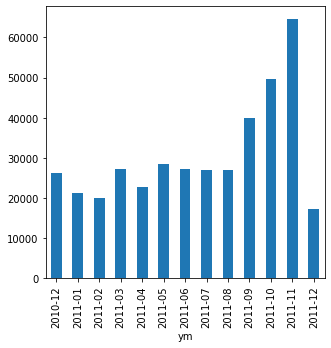

In [25]:
cleaned_retail_df.groupby(['ym'])['StockCode'].count().plot.bar(figsize=(5, 5))

- **`2011-09 ~ 2011-11`** 데이터를 train 데이터로 사용하고, **`2011-12`** 데이터를 test 데이터로 사용합니다.

In [26]:
cleaned_retail_df['ym'] = cleaned_retail_df['InvoiceDate'].apply(lambda x: str(x)[:7])
train_df = cleaned_retail_df[(cleaned_retail_df['ym'] >= '2011-09') & (cleaned_retail_df['ym'] <= '2011-11')]
test_df  = cleaned_retail_df[cleaned_retail_df['ym'] == '2011-12']

- 사용자 별로 groupby 하여 문서의 형태로 만들어줍니다.

In [27]:
train_groupby = train_df.groupby(['CustomerID'])
doc_list = []

for user_id, user_df in train_groupby:
    document = user_df['StockCode'].values.tolist()
    doc_list.append(document)

#### 학습 데이터 샘플

In [28]:
doc_list[100]

['22993',
 '16045',
 '22398',
 '22608',
 '22610',
 '21558',
 '16008',
 '23379',
 '23392',
 '23559',
 '90087',
 '23388',
 '23389',
 '21559',
 '22352',
 '35964',
 '22579',
 '21015',
 '21014',
 '22336',
 '23483',
 '23540',
 '23542',
 'POST',
 '22326',
 '21580',
 '22327',
 'POST']

#### gensim에서 지원하는 dictionary

In [29]:
id2word = corpora.Dictionary(doc_list)

#### 문서를 TF의 형태로 변환

In [30]:
corpus = [id2word.doc2bow(doc) for doc in doc_list]
print(corpus[100])

[(49, 2), (67, 1), (139, 1), (148, 1), (329, 1), (342, 1), (343, 1), (354, 1), (433, 1), (434, 1), (501, 1), (741, 1), (757, 1), (774, 1), (800, 1), (1035, 1), (1081, 1), (1192, 1), (1213, 1), (1403, 1), (1404, 1), (1405, 1), (1406, 1), (1407, 1), (1408, 1), (1409, 1), (1410, 1)]


### LDA 모델링

In [31]:
topic_num = 20
ldamodel  = gensim.models.ldamodel.LdaModel(corpus,
                                           num_topics = topic_num,
                                           id2word = id2word,
                                           passes=10)

#### 20개 토픽별 Top N 아이템 분포 확인

In [32]:
topics = ldamodel.print_topics(num_words = 5)
for topic in topics: print(topic)

(0, '0.033*"22749" + 0.033*"22568" + 0.032*"22750" + 0.029*"22940" + 0.029*"22144"')
(1, '0.035*"21137" + 0.030*"15056N" + 0.029*"15056BL" + 0.028*"22197" + 0.027*"23084"')
(2, '0.032*"POST" + 0.020*"22629" + 0.016*"22326" + 0.015*"22630" + 0.014*"23256"')
(3, '0.014*"84946" + 0.014*"84879" + 0.012*"22086" + 0.010*"22158" + 0.008*"23215"')
(4, '0.033*"22578" + 0.028*"22577" + 0.028*"23266" + 0.028*"23265" + 0.027*"23263"')
(5, '0.010*"22574" + 0.010*"22573" + 0.007*"23275" + 0.007*"22576" + 0.007*"22578"')
(6, '0.030*"21790" + 0.017*"21889" + 0.016*"21791" + 0.014*"22561" + 0.013*"22086"')
(7, '0.033*"85099B" + 0.031*"23203" + 0.024*"23344" + 0.023*"23202" + 0.022*"23209"')
(8, '0.020*"23293" + 0.015*"23296" + 0.015*"23295" + 0.011*"23294" + 0.010*"23240"')
(9, '0.060*"22726" + 0.057*"22727" + 0.042*"22728" + 0.034*"22730" + 0.029*"23084"')
(10, '0.023*"22423" + 0.020*"22699" + 0.019*"23245" + 0.019*"22697" + 0.017*"22698"')
(11, '0.014*"22138" + 0.009*"21891" + 0.009*"20975" + 0.008*"

In [33]:
for i in range(20):
    recommend = ldamodel.show_topic(topicid=i, topn=5)
    print(i, [stock_to_description[item] for item, score in recommend])

0 ['FELTCRAFT PRINCESS CHARLOTTE DOLL', 'FELTCRAFT CUSHION OWL', 'FELTCRAFT PRINCESS LOLA DOLL', 'FELTCRAFT CHRISTMAS FAIRY', 'CHRISTMAS CRAFT LITTLE FRIENDS']
1 ['BLACK RECORD COVER FRAME', 'EDWARDIAN PARASOL NATURAL', 'EDWARDIAN PARASOL BLACK', 'POPCORN HOLDER', 'RABBIT NIGHT LIGHT']
2 ['POSTAGE', 'SPACEBOY LUNCH BOX ', 'ROUND SNACK BOXES SET OF4 WOODLAND ', 'DOLLY GIRL LUNCH BOX', 'CHILDRENS CUTLERY SPACEBOY ']
3 ['ANTIQUE SILVER T-LIGHT GLASS', 'ASSORTED COLOUR BIRD ORNAMENT', "PAPER CHAIN KIT 50'S CHRISTMAS ", '3 HEARTS HANGING DECORATION RUSTIC', 'JINGLE BELL HEART ANTIQUE SILVER']
4 ['WOODEN STAR CHRISTMAS SCANDINAVIAN', 'WOODEN HEART CHRISTMAS SCANDINAVIAN', 'SET OF 3 WOODEN STOCKING DECORATION', 'SET OF 3 WOODEN TREE DECORATIONS', 'SET OF 3 WOODEN HEART DECORATIONS']
5 ['HEART WOODEN CHRISTMAS DECORATION', 'STAR WOODEN CHRISTMAS DECORATION', 'SET OF 3 HANGING OWLS OLLIE BEAK', 'SWALLOW WOODEN CHRISTMAS DECORATION', 'WOODEN STAR CHRISTMAS SCANDINAVIAN']
6 ['VINTAGE SNAP CARDS',

#### 유저의 토픽 분포를 구해봅시다

In [34]:
user_topic_dict = {}
for user_id, user_df in train_groupby:
    document = user_df['StockCode'].values.tolist()
    user_topic_dict[user_id] = ldamodel.get_document_topics(id2word.doc2bow(document), minimum_probability=0.0)

In [35]:
user_id = 12682
user_topic_dict[user_id]

[(0, 0.016125945),
 (1, 0.10703708),
 (2, 0.42855385),
 (3, 0.00035468393),
 (4, 0.00035468393),
 (5, 0.00035468393),
 (6, 0.023952905),
 (7, 0.21593425),
 (8, 0.12408726),
 (9, 0.00035468393),
 (10, 0.042694774),
 (11, 0.00035468393),
 (12, 0.00035468393),
 (13, 0.00035468393),
 (14, 0.00035468393),
 (15, 0.037357707),
 (16, 0.00035468393),
 (17, 0.00035468393),
 (18, 0.00035468393),
 (19, 0.00035468393)]

## 04. LDA로 유저에게 추천

### 유저 토픽 가운데 확률이 높은 topic을 이용한 추천
- 유저의 토픽 분포를 확인하고 가장 확률이 높은 토픽을 선택합니다.
- 해당 토픽에 속한 Top N 아이템을 추천합니다.
- example: user - 12682, n - 20

In [36]:
topn = 20
user_id = 12682
user_topics = user_topic_dict[user_id]
user_topics = sorted(user_topics, key=lambda x: (x[1]), reverse=True)
user_topic = user_topics[0][0]

recommend = ldamodel.show_topic(topicid = user_topic, topn=topn)
recommend = [item for item, score in recommend]
recommend

['POST',
 '22629',
 '22326',
 '22630',
 '23256',
 '23389',
 '23254',
 '22328',
 '22382',
 '21669',
 '22551',
 '22467',
 '22554',
 '23390',
 '23388',
 '21212',
 '21668',
 '21731',
 '23292',
 '23290']

In [37]:
user_topic

2

#### 실제 유저가 test 데이터에서 선호한(구매한) 아이템

In [38]:
relevant = test_df[test_df['CustomerID'] == user_id]['StockCode'].unique()
list(relevant)

['20750',
 '21931',
 '85099B',
 '22423',
 '21242',
 '21243',
 '21239',
 '21240',
 '23040',
 '22596',
 '22456',
 '48185',
 '21770',
 '21977',
 '21212',
 '84375',
 '23163',
 '84378',
 '23020',
 '22966',
 '23084',
 '22556',
 '22551',
 '22555',
 '47566',
 '23192',
 '22139',
 '22138',
 '22467',
 'POST']

In [39]:
def get_precision(relevant, recommend):
    _intersection = set(recommend).intersection(set(relevant))
    return len(_intersection) / len(recommend)

def get_recall(relevant, recommend):
    _intersection = set(recommend).intersection(set(relevant))
    return len(_intersection) / len(relevant)

In [40]:
# Precision
print(get_precision(relevant, recommend))

# Recall
print(get_recall(relevant, recommend))

0.2
0.13333333333333333


### Top N 추천 성능 평가
- 유저별로 추천하여 전체 성능을 구해봅시다

In [41]:
train_user_ids = train_df['CustomerID'].unique()
test_user_ids  = test_df['CustomerID'].unique()
topn = 20

default_recommend = list(train_df.groupby('StockCode')['Quantity'].count().sort_values(ascending=False)[:topn].index)

precisions = []
recalls = []

for user_id in test_user_ids:
    if user_id in train_user_ids:
        user_topics = user_topic_dict[user_id]
        user_topics = sorted(user_topics, key=lambda x: (x[1]), reverse=True)
        user_topic  = user_topics[0][0]
        recommend = [item for item, score in ldamodel.show_topic(topicid = user_topic, topn=topn)]
    else:
        recommend = default_recommend
        
    relevant = test_df[test_df['CustomerID'] == user_id]['StockCode'].unique()
    precisions.append(get_precision(relevant, recommend))
    recalls.append(get_recall(relevant, recommend))
    
print("precision@k:", np.mean(np.asarray(precisions)))
print("recall@k:", np.mean(np.asarray(recalls)))

precision@k: 0.1078048780487805
recall@k: 0.12760624395007583
